# Representation learning for bone fractures


In [1]:
# Basic Libraries
import os
from pathlib import Path

# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Deep Learning Libraries
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn import functional as F
from torchvision.models import resnet50

# Deep Learning Data Libraries
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Machine Learning Libraries
from sklearn.model_selection import train_test_split

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing Libraries
from PIL import Image



# Deep Learning Visualization Libraries
from tqdm import tqdm


# Data preprocessing

In [2]:
# Define the size to resize images to
size = (224, 224)

# Define the path to the data directory
train_dir = Path('train')
test_dir = Path('valid')

In [3]:
class ImageDataset(Dataset):
    """Custom Dataset for loading and preprocessing images on-the-fly"""
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['file_path']
        label = row['label']
        # Load and preprocess the image
        with Image.open(image_path) as img:
            img_gray = img.convert('L')
            if self.transform:
                img_gray = self.transform(img_gray)
        return img_gray, label

In [4]:
def load_data(data_dir):
    # Initialize lists to hold file paths, labels, and body parts
    file_paths = []
    labels = []
    body_parts = []

    # Loop over all the body parts directories in the data directory
    for body_part_dir in data_dir.iterdir():
        body_part = body_part_dir.name.split('_')[-1]

        # Loop over all the patient directories in each body part directory
        for patient_dir in body_part_dir.iterdir():

            # Loop over all the study directories in each patient directory
            for study_dir in patient_dir.iterdir():

                # Get the label from the study directory name ('positive' or 'negative')
                label = str(study_dir).split('_')[-1]

                # Loop over all the images in each study directory
                for image_path in study_dir.glob('*.png'):

                    # Append the data to the lists
                    file_paths.append(image_path)
                    labels.append(label)
                    body_parts.append(body_part)

    # Create a DataFrame from the lists
    df = pd.DataFrame({
        'file_path': file_paths,
        'label': labels,
        'body_part': body_parts,
    })

    # Map the labels to integers
    label_mapping = {'positive': 1, 'negative': 0}
    df['label'] = df['label'].map(label_mapping)

    return df

In [5]:

# Load training and validation data
train_df = load_data(train_dir)
test_df = load_data(test_dir)

# Split the train dataset into train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)




In [6]:
# Define data transformations
train_transforms = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_transforms = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transforms = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [7]:
# Create ImageDataset objects for the training set, validation set, and test set
train_dataset = ImageDataset(train_df, transform=train_transforms)
val_dataset = ImageDataset(val_df, transform=val_transforms)
test_dataset = ImageDataset(test_df, transform=test_transforms)

# Create DataLoaders for the training set, validation set, and test set
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)


# EDA

info for Training dataframe:
Training data shape: (15082, 3)

Distribution of Labels:
label
0    8931
1    6151
Name: count, dtype: int64

Distribution of Body Parts:
body_part
SHOULDER    6752
HAND        4377
ELBOW       3953
Name: count, dtype: int64

Distribution of Labels in Each Body Part:
body_part  label
ELBOW      0        2333
           1        1620
HAND       0        3198
           1        1179
SHOULDER   0        3400
           1        3352
Name: count, dtype: int64


info for Validation dataframe:
Validation data shape: (3771, 3)

Distribution of Labels:
label
0    2264
1    1507
Name: count, dtype: int64

Distribution of Body Parts:
body_part
SHOULDER    1627
HAND        1166
ELBOW        978
Name: count, dtype: int64

Distribution of Labels in Each Body Part:
body_part  label
ELBOW      0        592
           1        386
HAND       0        861
           1        305
SHOULDER   1        816
           0        811
Name: count, dtype: int64


info for Test dataf

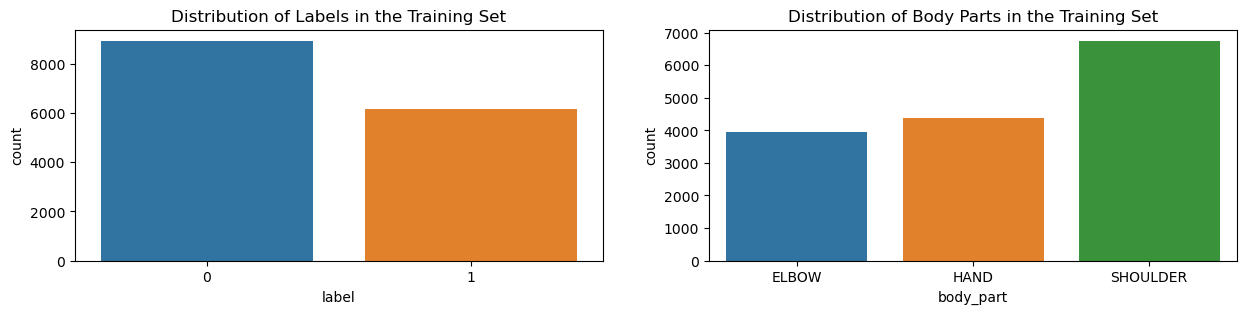

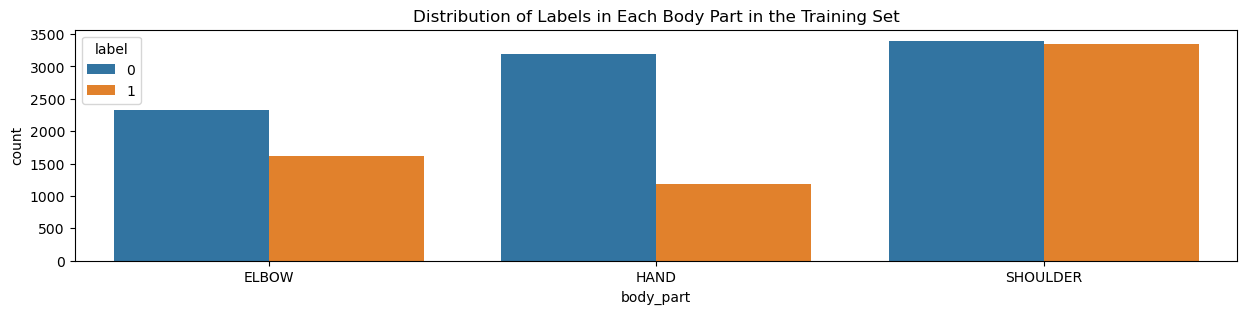

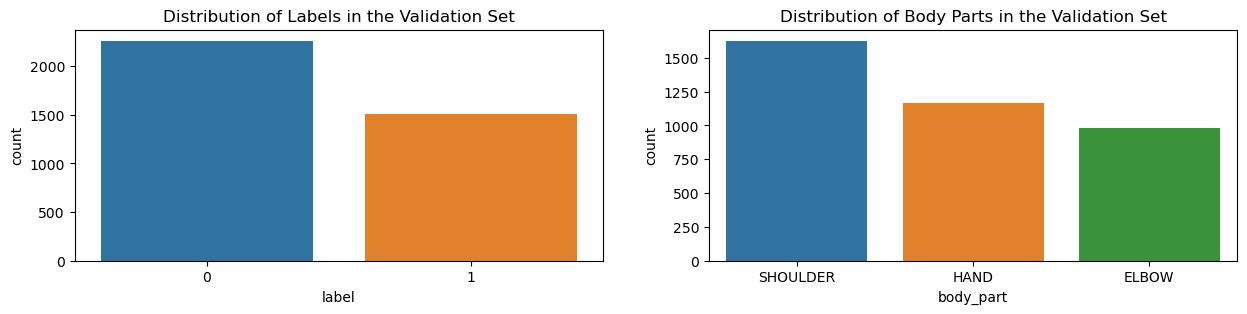

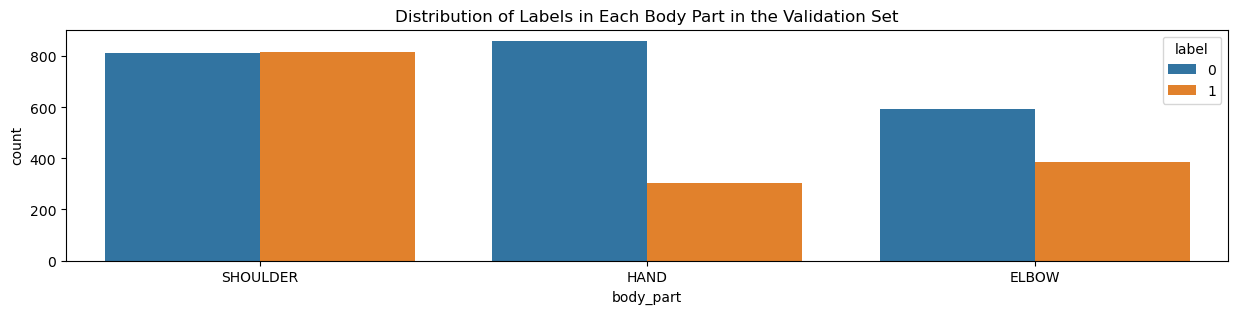

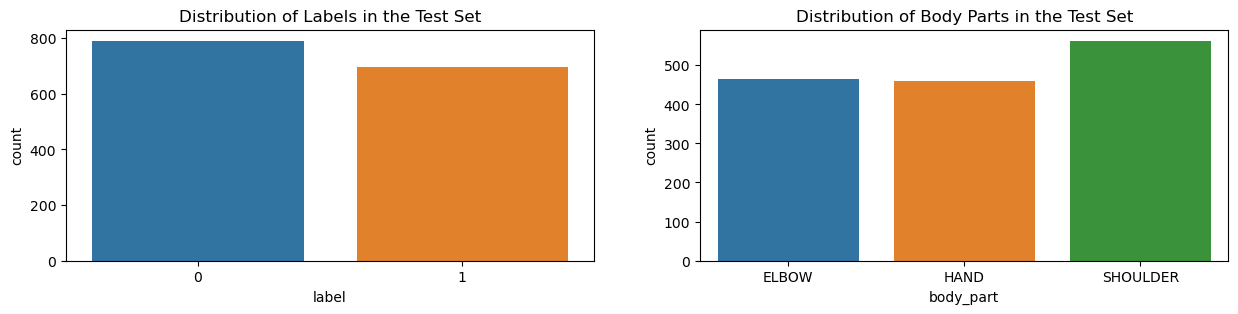

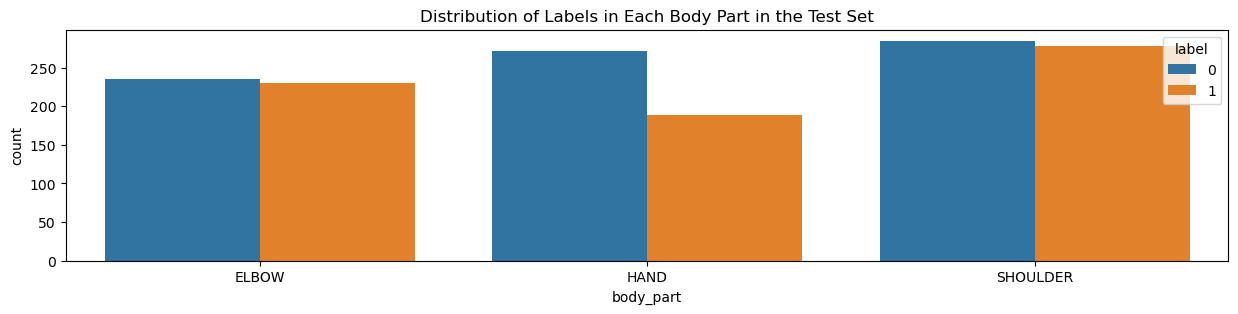

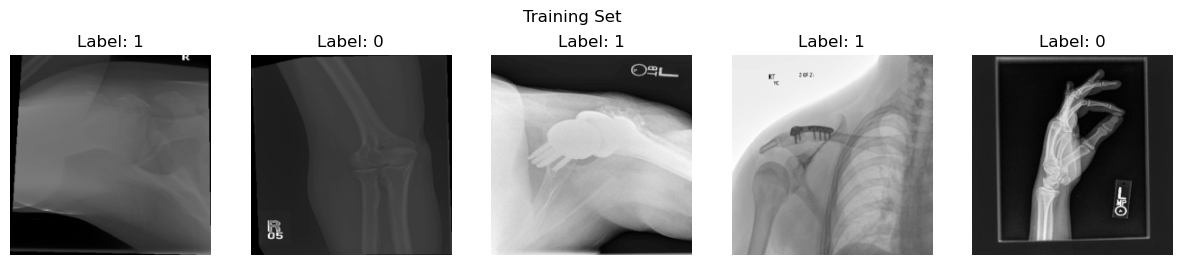

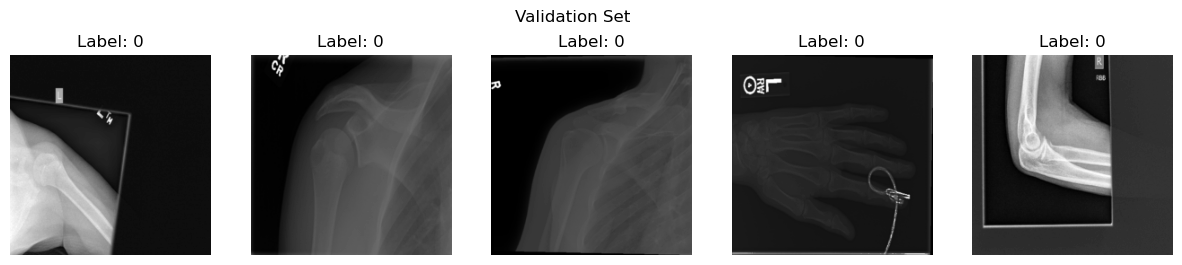

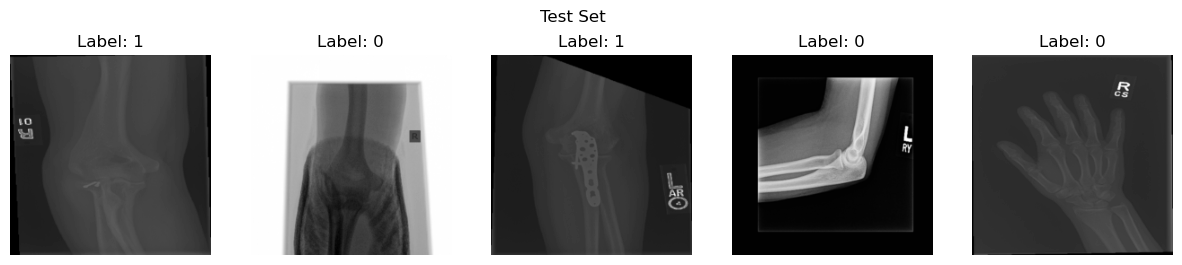

In [8]:
def print_dataframe_info(df, name):
    """Prints the shape and distribution of labels and body parts in a dataframe"""
    print("info for {} dataframe:".format(name))
    print(f"{name} data shape: {df.shape}")
    print("\nDistribution of Labels:")
    print(df['label'].value_counts())
    print("\nDistribution of Body Parts:")
    print(df['body_part'].value_counts())
    print("\nDistribution of Labels in Each Body Part:")
    print(df.groupby('body_part')['label'].value_counts())
    print("\n")


def plot_dataframe_distribution(df, title):
    """Plots the distribution of labels and body parts in a dataframe"""
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 2, 1)
    sns.countplot(data=df, x='label')
    plt.title(f"Distribution of Labels in the {title}")
    plt.subplot(1, 2, 2)
    sns.countplot(data=df, x='body_part')
    plt.title(f"Distribution of Body Parts in the {title}")
    # plot distribution of labels in each body part
    plt.figure(figsize=(15, 3))
    sns.countplot(data=df, x='body_part', hue='label')
    plt.title(f"Distribution of Labels in Each Body Part in the {title}")
    plt.show()


def plot_sample_images(dataloader, title):
    """Plot some sample images from the dataloader"""
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(title)
    
    for i, (images, labels) in enumerate(dataloader):
        if i == 5:
            break
        ax = axs[i % 5]
        ax.imshow(images[0].squeeze(), cmap='gray')
        ax.set_title(f"Label: {labels[0]}")
        ax.axis('off')
    plt.show()

# Print the shape and distribution of labels and body parts in the training, validation, and test dataframes
print_dataframe_info(train_df, "Training")
print_dataframe_info(val_df, "Validation")
print_dataframe_info(test_df, "Test")

# Plot the distribution of labels and body parts in the training, validation, and test dataframes
plot_dataframe_distribution(train_df, "Training Set")
plot_dataframe_distribution(val_df, "Validation Set")
plot_dataframe_distribution(test_df, "Test Set")

# Plot some sample images from the training, validation, and test dataloaders
plot_sample_images(train_dataloader, "Training Set")
plot_sample_images(val_dataloader, "Validation Set")
plot_sample_images(test_dataloader, "Test Set")


# Base Model

In [9]:

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [10]:
base_model = SimpleCNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
base_model.to(device)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(base_model.parameters(), lr=0.001)

cuda:0


In [11]:

# Train the model
n_epochs = 10
train_loss_history = []
valid_loss_history = []
train_acc_history = []
valid_acc_history = []

for epoch in tqdm(range(n_epochs)):
    base_model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = base_model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        predicted = (outputs.squeeze() > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = train_loss / len(train_dataloader.dataset)
    train_accuracy = correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_accuracy)

    base_model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = base_model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            valid_loss += loss.item() * inputs.size(0)
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    valid_loss = valid_loss / len(val_dataloader.dataset)
    valid_accuracy = correct / total
    valid_loss_history.append(valid_loss)
    valid_acc_history.append(valid_accuracy)

    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}')

# Save the model
torch.save(base_model.state_dict(), 'base_model.pth')
# save the training history
torch.save({
    'train_loss_history': train_loss_history,
    'valid_loss_history': valid_loss_history,
    'train_acc_history': train_acc_history,
    'valid_acc_history': valid_acc_history
}, 'base_model_history.pth')


 10%|█         | 1/10 [01:30<13:34, 90.47s/it]

Epoch 1/10, Train Loss: 0.7209, Train Accuracy: 0.5883, Validation Loss: 0.6516, Validation Accuracy: 0.6126


 20%|██        | 2/10 [02:45<10:51, 81.43s/it]

Epoch 2/10, Train Loss: 0.6448, Train Accuracy: 0.6245, Validation Loss: 0.6328, Validation Accuracy: 0.6433


 30%|███       | 3/10 [04:00<09:10, 78.61s/it]

Epoch 3/10, Train Loss: 0.6247, Train Accuracy: 0.6483, Validation Loss: 0.6294, Validation Accuracy: 0.6497


 40%|████      | 4/10 [05:15<07:42, 77.05s/it]

Epoch 4/10, Train Loss: 0.5982, Train Accuracy: 0.6741, Validation Loss: 0.6296, Validation Accuracy: 0.6447


 50%|█████     | 5/10 [06:30<06:21, 76.22s/it]

Epoch 5/10, Train Loss: 0.5623, Train Accuracy: 0.6997, Validation Loss: 0.6436, Validation Accuracy: 0.6510


 60%|██████    | 6/10 [07:44<05:02, 75.68s/it]

Epoch 6/10, Train Loss: 0.5050, Train Accuracy: 0.7429, Validation Loss: 0.6854, Validation Accuracy: 0.6401


 70%|███████   | 7/10 [08:59<03:46, 75.50s/it]

Epoch 7/10, Train Loss: 0.4376, Train Accuracy: 0.7874, Validation Loss: 0.7398, Validation Accuracy: 0.6486


 80%|████████  | 8/10 [10:16<02:31, 75.76s/it]

Epoch 8/10, Train Loss: 0.3525, Train Accuracy: 0.8350, Validation Loss: 0.8185, Validation Accuracy: 0.6444


 90%|█████████ | 9/10 [11:30<01:15, 75.35s/it]

Epoch 9/10, Train Loss: 0.2764, Train Accuracy: 0.8787, Validation Loss: 0.9170, Validation Accuracy: 0.6494


100%|██████████| 10/10 [12:45<00:00, 76.52s/it]

Epoch 10/10, Train Loss: 0.2069, Train Accuracy: 0.9143, Validation Loss: 1.1562, Validation Accuracy: 0.6468


In [12]:
# load the model
base_model.load_state_dict(torch.load('base_model.pth'))
# load the training history
checkpoint = torch.load('base_model_history.pth')
train_loss_history = checkpoint['train_loss_history']
valid_loss_history = checkpoint['valid_loss_history']
train_acc_history = checkpoint['train_acc_history']
valid_acc_history = checkpoint['valid_acc_history']

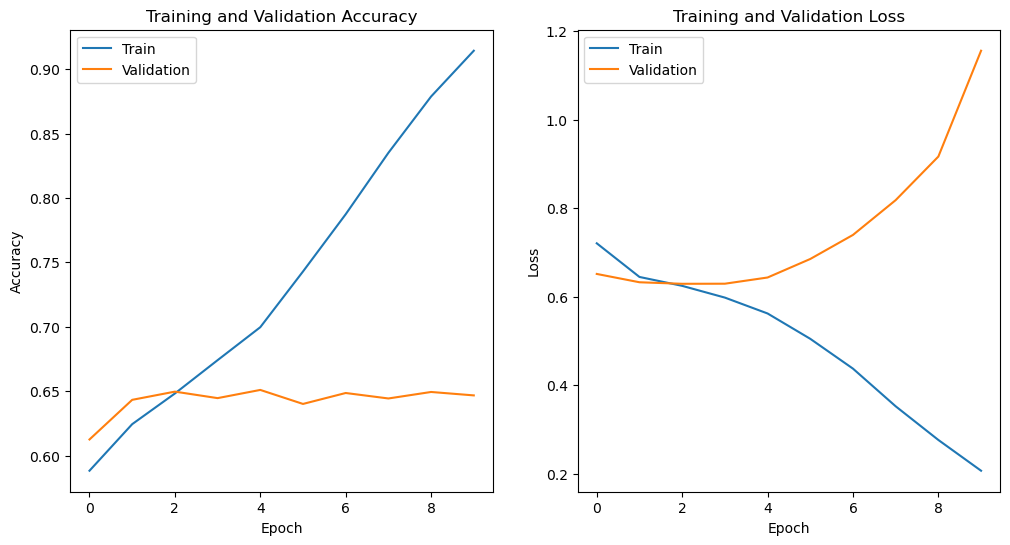

In [13]:

# plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Train')
plt.plot(valid_acc_history, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy")

# plot the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Train')
plt.plot(valid_loss_history, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss")

plt.show()


# part 2 - BYOL model

In [23]:
# Define new data transformations for the new views
# Define new data transformations for the new views
train_new_view_transforms = transforms.Compose([
    transforms.Resize(size),
    transforms.RandomChoice([
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
    ]),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create new ImageDataset objects for the new views
train_new_view_dataset = ImageDataset(train_df, transform=train_new_view_transforms)

# Create new DataLoaders for the new views
train_new_view_dataloader = DataLoader(train_new_view_dataset, batch_size=128, shuffle=True)

# Create new ImageDataset objects for the new views
train_new_view_dataset = ImageDataset(train_df, transform=train_new_view_transforms)

# Create new DataLoaders for the new views
train_new_view_dataloader = DataLoader(train_new_view_dataset, batch_size=128, shuffle=True)

In [24]:
# Implementing the MLP Head
class MLPHead(nn.Module):
    def __init__(self, in_features, hidden_size, out_features):
        super().__init__()
        self.linear1 = nn.Linear(in_features, hidden_size)
        self.linear2 = nn.Linear(hidden_size, out_features)

    def forward(self, x):
        x = nn.functional.relu(self.linear1(x))
        x = self.linear2(x)
        return x

# Implementing the BYOL model
class BYOL(nn.Module):
    def __init__(self, feature_dim=256):
        super().__init__()

        # Define the backbone (a ResNet model)
        self.backbone = resnet50(pretrained=True)

        # freeze the backbone
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Define the projection head
        self.projection_head = MLPHead(self.backbone.fc.in_features, hidden_size=4096, out_features=feature_dim)

        # Define the prediction head
        self.prediction_head = MLPHead(feature_dim, hidden_size=4096, out_features=feature_dim)

        # Remove the fully connected layer from the backbone
        self.backbone.fc = nn.Identity()

    def forward(self, x):
        # Extend the 1 channel image to 3 channels (required by ResNet)
        x = torch.cat([x, x, x], dim=1)
        # Get the representation from the backbone
        x = self.backbone(x)
        # Project the representation
        x = self.projection_head(x)
        x = self.prediction_head(x)
        return x

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
# Initialize the model
byol_model = BYOL().to(device)

# Initialize the target model
target_model = BYOL().to(device)
target_model.load_state_dict(byol_model.state_dict())

# Specify the training parameters
lr = 0.001
epochs = 10
tau = 0.99 # target model update parameter

# Initialize the optimizer
optimizer = Adam(byol_model.parameters(), lr=lr)

# Initialize the LR scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

# Load your dataset

# Initialize the loss variable
loss = None

# Training loop
for epoch in tqdm(range(epochs)):
    byol_model.train()
    for (images, _), (images_new_view, _) in zip(train_dataloader, train_new_view_dataloader):
        images = images.to(device)
        images_new_view = images_new_view.to(device)

        # Forward pass
        p1 = byol_model(images)
        p2 = byol_model(images_new_view)

        # Normalize the predictions
        p1 = F.normalize(p1, dim=-1)
        p2 = F.normalize(p2, dim=-1)

        # Compute the loss
        loss = 2 - 2 * (p1 * p2.detach()).sum(dim=-1).mean()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the target network
        for param, target_param in zip(byol_model.parameters(), target_model.parameters()):
            target_param.data = tau * target_param.data + (1 - tau) * param.data

    scheduler.step()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')


Using device: cuda


 10%|█         | 1/10 [02:13<20:01, 133.50s/it]

Epoch 1/10, Loss: 0.0000


 20%|██        | 2/10 [04:24<17:37, 132.14s/it]

Epoch 2/10, Loss: 0.0000


 30%|███       | 3/10 [06:32<15:09, 129.99s/it]

Epoch 3/10, Loss: 0.0000


 40%|████      | 4/10 [08:40<12:56, 129.45s/it]

Epoch 4/10, Loss: 0.0000


 50%|█████     | 5/10 [10:43<10:35, 127.07s/it]

Epoch 5/10, Loss: 0.0000


 60%|██████    | 6/10 [12:44<08:20, 125.04s/it]

Epoch 6/10, Loss: 0.0000


 70%|███████   | 7/10 [14:48<06:13, 124.66s/it]

Epoch 7/10, Loss: 0.0000


 80%|████████  | 8/10 [16:50<04:07, 123.64s/it]

Epoch 8/10, Loss: 0.0000


 90%|█████████ | 9/10 [18:57<02:04, 124.79s/it]

Epoch 9/10, Loss: 0.0000


100%|██████████| 10/10 [21:02<00:00, 126.20s/it]

Epoch 10/10, Loss: 0.0000


In [17]:
# save the model
torch.save(byol_model.state_dict(), 'byol_model.pth')

# BYOL Classifier

In [18]:
# Define a new model for classification
class BYOLClassifier(nn.Module):
    def __init__(self, byol_model, num_classes):
        super().__init__()
        self.base = byol_model.backbone
        # freeze the base
        for param in self.base.parameters():
            param.requires_grad = False
        # define the projection head
        self.projection_head = byol_model.projection_head
        self.classifier = nn.Linear(self.projection_head.linear2.out_features, num_classes)
        
    def forward(self, x):
        x = torch.cat([x, x, x], dim=1)
        x = self.base(x)
        x = self.projection_head(x)
        x = self.classifier(x)
        return x

# Instantiate the classification model
classification_byol_model = BYOLClassifier(byol_model=byol_model, num_classes=2).to(device)



In [19]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classification_byol_model.parameters(), lr=0.001)

# Define the number of epochs to train for
num_epochs = 10

# define history variables
train_loss_history_byol = []
train_acc_history_byol = []
val_loss_history_byol = []
val_acc_history_byol = []

# Loop over the epochs
for epoch in tqdm(range(num_epochs)):
    # Keep track of the loss and number of correct predictions for training and validation
    running_loss_train = 0.0
    running_corrects_train = 0
    running_loss_val = 0.0
    running_corrects_val = 0
    
    # Loop over the training data
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = classification_byol_model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Update running loss and corrects for training
        running_loss_train += loss.item() * inputs.size(0)
        running_corrects_train += torch.sum(preds == labels.data)
    
    # Calculate training loss and accuracy
    epoch_loss_train = running_loss_train / len(train_dataloader.dataset)
    epoch_acc_train = running_corrects_train.float() / len(train_dataloader.dataset)
    
    # Append training loss and accuracy to history variables
    train_loss_history_byol.append(epoch_loss_train)
    train_acc_history_byol.append(epoch_acc_train.item())
    
    # Loop over the validation data
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = classification_byol_model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Update running loss and corrects for validation
            running_loss_val += loss.item() * inputs.size(0)
            running_corrects_val += torch.sum(preds == labels.data)

    # Calculate validation loss and accuracy
    epoch_loss_val = running_loss_val / len(val_dataloader.dataset)
    epoch_acc_val = running_corrects_val.float() / len(val_dataloader.dataset)
    
    # Append validation loss and accuracy to history variables
    val_loss_history_byol.append(epoch_loss_val)
    val_acc_history_byol.append(epoch_acc_val.item())
    
    # Print epoch statistics for training and validation
    print('Epoch {}/{} Train Loss: {:.4f} Train Acc: {:.4f} Val Loss: {:.4f} Val Acc: {:.4f}'.format(epoch, num_epochs - 1, epoch_loss_train, epoch_acc_train, epoch_loss_val, epoch_acc_val))

print('Finished Training')

# save the classification_byol_model
torch.save(classification_byol_model.state_dict(), 'classification_byol_model.pth')
# save the history
torch.save({'train_loss_history_byol': train_loss_history_byol,
            'train_acc_history_byol': train_acc_history_byol,
            'val_loss_history_byol': val_loss_history_byol,
            'val_acc_history_byol': val_acc_history_byol}, 'history_byol.pth')


 10%|█         | 1/10 [01:35<14:22, 95.82s/it]

Epoch 0/9 Train Loss: 1.2821 Train Acc: 0.6301 Val Loss: 0.5872 Val Acc: 0.7136


 20%|██        | 2/10 [03:11<12:45, 95.68s/it]

Epoch 1/9 Train Loss: 0.5883 Train Acc: 0.7004 Val Loss: 0.6474 Val Acc: 0.6590


 30%|███       | 3/10 [04:46<11:08, 95.54s/it]

Epoch 2/9 Train Loss: 0.5803 Train Acc: 0.7042 Val Loss: 0.5538 Val Acc: 0.7298


 40%|████      | 4/10 [06:22<09:32, 95.47s/it]

Epoch 3/9 Train Loss: 0.5713 Train Acc: 0.7154 Val Loss: 0.5481 Val Acc: 0.7343


 50%|█████     | 5/10 [07:57<07:56, 95.35s/it]

Epoch 4/9 Train Loss: 0.5548 Train Acc: 0.7270 Val Loss: 0.5448 Val Acc: 0.7335


 60%|██████    | 6/10 [09:32<06:21, 95.36s/it]

Epoch 5/9 Train Loss: 0.5608 Train Acc: 0.7211 Val Loss: 0.5595 Val Acc: 0.7200


 70%|███████   | 7/10 [11:07<04:46, 95.35s/it]

Epoch 6/9 Train Loss: 0.5444 Train Acc: 0.7327 Val Loss: 0.5436 Val Acc: 0.7385


 80%|████████  | 8/10 [12:43<03:10, 95.31s/it]

Epoch 7/9 Train Loss: 0.5343 Train Acc: 0.7386 Val Loss: 0.5368 Val Acc: 0.7422


 90%|█████████ | 9/10 [14:18<01:35, 95.37s/it]

Epoch 8/9 Train Loss: 0.5356 Train Acc: 0.7392 Val Loss: 0.5391 Val Acc: 0.7399


100%|██████████| 10/10 [15:53<00:00, 95.40s/it]

Epoch 9/9 Train Loss: 0.5243 Train Acc: 0.7469 Val Loss: 0.5344 Val Acc: 0.7436
Finished Training


In [20]:
# load the model
classification_byol_model.load_state_dict(torch.load('classification_byol_model.pth'))
# load the history
history_byol = torch.load('history_byol.pth')
# extract the history variables
train_loss_history_byol = history_byol['train_loss_history_byol']
train_acc_history_byol = history_byol['train_acc_history_byol']
val_loss_history_byol = history_byol['val_loss_history_byol']
val_acc_history_byol = history_byol['val_acc_history_byol']

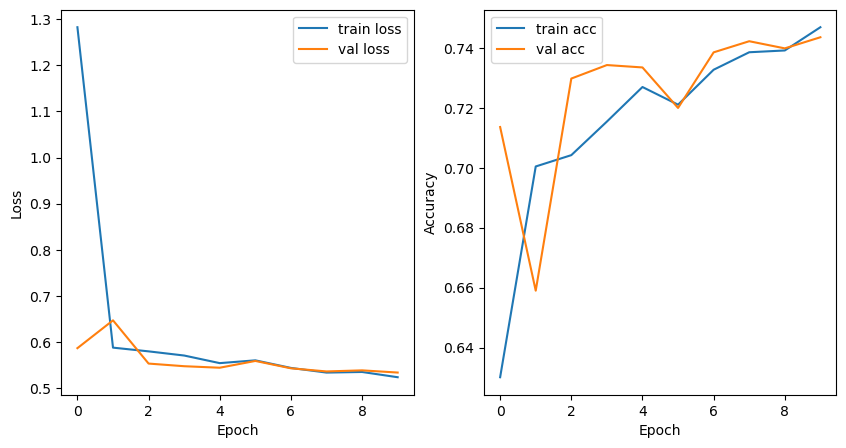

In [21]:
# plot the history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history_byol, label='train loss')
plt.plot(val_loss_history_byol, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc_history_byol, label='train acc')
plt.plot(val_acc_history_byol, label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



# comparison of the two models

Test Accuracy Base Model: 0.5316
Test Accuracy Classification BYOL Model: 0.6902
Difference in Test Accuracy: 0.1586
Number of Correct Predictions Base Model: 791
Number of Correct Predictions Classification BYOL Model: 1027
Difference in Number of Correct Predictions: 236


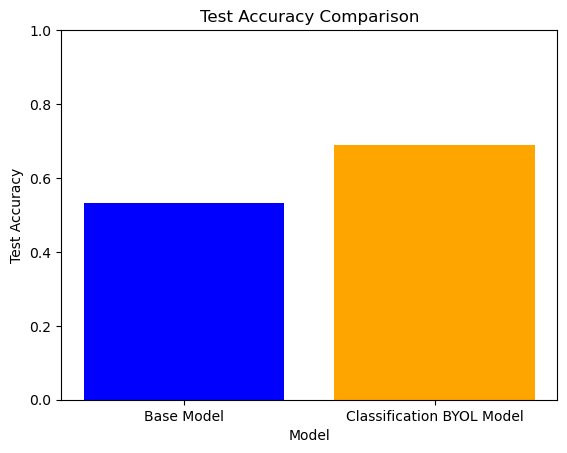

In [26]:
# compare the two models (base_model and classification_byol_model)

# define the test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# define the number of correct predictions for the two models
corrects_base_model = 0
corrects_classification_byol_model = 0

# Loop over the test data
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs_base_model = base_model(inputs)
        _, preds_base_model = torch.max(outputs_base_model, 1)
        outputs_classification_byol_model = classification_byol_model(inputs)
        _, preds_classification_byol_model = torch.max(outputs_classification_byol_model, 1)
        
        # Update corrects for the two models
        corrects_base_model += torch.sum(preds_base_model == labels.data)
        corrects_classification_byol_model += torch.sum(preds_classification_byol_model == labels.data)

# Calculate test accuracy for the two models
test_acc_base_model = corrects_base_model.float() / len(test_dataloader.dataset)
test_acc_classification_byol_model = corrects_classification_byol_model.float() / len(test_dataloader.dataset)

# Print test accuracy for the two models
print('Test Accuracy Base Model: {:.4f}'.format(test_acc_base_model))
print('Test Accuracy Classification BYOL Model: {:.4f}'.format(test_acc_classification_byol_model))

# Print the difference in test accuracy between the two models
print('Difference in Test Accuracy: {:.4f}'.format(test_acc_classification_byol_model - test_acc_base_model))

# Print the number of correct predictions for the two models
print('Number of Correct Predictions Base Model: {:.0f}'.format(corrects_base_model))
print('Number of Correct Predictions Classification BYOL Model: {:.0f}'.format(corrects_classification_byol_model))

# Print the difference in the number of correct predictions between the two models
print('Difference in Number of Correct Predictions: {:.0f}'.format(corrects_classification_byol_model - corrects_base_model))

# Define the data for the bar plot
test_accs = [test_acc_base_model.item(), test_acc_classification_byol_model.item()]
model_names = ['Base Model', 'Classification BYOL Model']
colors = ['blue', 'orange']

# Create the bar plot
plt.bar(model_names, test_accs, color=colors)
plt.title('Test Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.ylim([0, 1])
plt.show()